In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
!unzip "//content/drive/MyDrive/data/FruitinAmazon.zip"

Archive:  //content/drive/MyDrive/data/FruitinAmazon.zip
  inflating: FruitinAmazon/test/cupuacu/download (5).jpeg  
  inflating: FruitinAmazon/test/acai/images (2).jpeg  
  inflating: FruitinAmazon/test/cupuacu/download (3).jpeg  
  inflating: FruitinAmazon/test/acai/images (16).jpeg  
  inflating: FruitinAmazon/test/pupunha/download (2).jpeg  
  inflating: FruitinAmazon/train/pupunha/images (1).jpeg  
  inflating: FruitinAmazon/test/cupuacu/download (2).jpeg  
  inflating: FruitinAmazon/test/pupunha/download (1).jpeg  
  inflating: FruitinAmazon/train/acai/images (3).jpeg  
  inflating: FruitinAmazon/train/acai/images (4).jpeg  
  inflating: FruitinAmazon/test/graviola/download (1).jpeg  
  inflating: FruitinAmazon/test/pupunha/download (11).jpeg  
  inflating: FruitinAmazon/test/pupunha/download (4).jpeg  
  inflating: FruitinAmazon/train/acai/images (11).jpeg  
  inflating: FruitinAmazon/test/tucuma/download (1).jpeg  
  inflating: FruitinAmazon/test/acai/images.jpeg  
  inflating:

In [4]:
!pip install keras tensorflow

In [5]:
import tensorflow as tf
print(tf.keras.__version__)

3.8.0


Task 1

In [6]:
import os
import random
import matplotlib.pyplot as plt
import tensorflow as tf


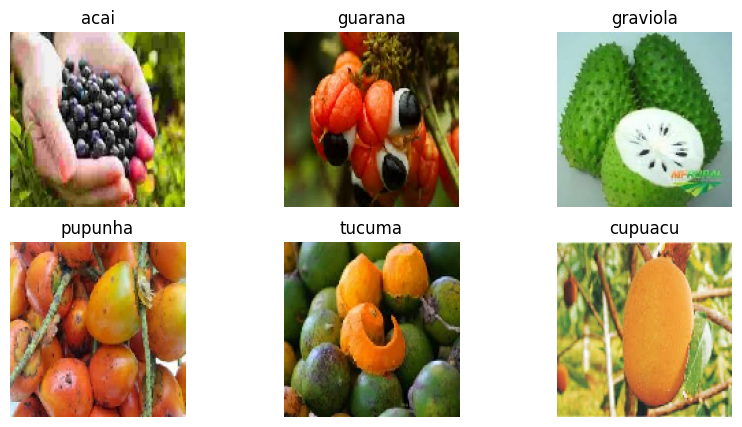

No corrupted images found.


In [7]:

# Task 1: Load and Visualize Data
def load_and_visualize_images(train_dir):
    class_names = os.listdir(train_dir)
    selected_images = []

    for class_name in class_names:
        class_path = os.path.join(train_dir, class_name)
        if os.path.isdir(class_path):  # Ensure it's a directory
            image_name = random.choice(os.listdir(class_path))
            image_path = os.path.join(class_path, image_name)
            selected_images.append((image_path, class_name))

    fig, axes = plt.subplots(2, len(selected_images)//2, figsize=(10, 5))
    axes = axes.flatten()
    for ax, (img_path, label) in zip(axes, selected_images):
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=(128, 128))
        ax.imshow(img)
        ax.set_title(label)
        ax.axis('off')
    plt.show()

# Task 1.2: Check for Corrupted Images
def check_corrupted_images(train_dir):
    corrupted_images = []
    for class_name in os.listdir(train_dir):
        class_path = os.path.join(train_dir, class_name)
        if os.path.isdir(class_path):  # Ensure it's a directory
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                try:
                    img = tf.keras.preprocessing.image.load_img(img_path)
                except (IOError, SyntaxError):
                    corrupted_images.append(img_path)
                    os.remove(img_path)
                    print(f"Removed corrupted image: {img_path}")

    if not corrupted_images:
        print("No corrupted images found.")

# Example Usage
train_dir = "FruitinAmazon/train"
load_and_visualize_images(train_dir)
check_corrupted_images(train_dir)


Task 2

In [8]:
import tensorflow as tf

def load_and_preprocess_data(train_dir, img_height, img_width, batch_size, validation_split):
    rescale = tf.keras.layers.Rescaling(1./255)

    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        train_dir,
        labels='inferred',
        label_mode='int',
        image_size=(img_height, img_width),
        interpolation='nearest',
        batch_size=batch_size,
        shuffle=True,
        validation_split=validation_split,
        subset='training',
        seed=123
    )

    train_ds = train_ds.map(lambda x, y: (rescale(x), y))

    val_ds = tf.keras.preprocessing.image_dataset_from_directory(
        train_dir,
        labels='inferred',
        label_mode='int',
        image_size=(img_height, img_width),
        interpolation='nearest',
        batch_size=batch_size,
        shuffle=False,
        validation_split=validation_split,
        subset='validation',
        seed=123
    )

    val_ds = val_ds.map(lambda x, y: (rescale(x), y))

    return train_ds, val_ds

# Example usage
img_height = 128
img_width = 128
batch_size = 32
validation_split = 0.2
train_ds, val_ds = load_and_preprocess_data(train_dir, img_height, img_width, batch_size, validation_split)



Found 90 files belonging to 6 classes.
Using 72 files for training.
Found 90 files belonging to 6 classes.
Using 18 files for validation.


Task 3

In [9]:
from tensorflow.keras import layers, models

def create_cnn_model(num_classes, input_shape):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

# Example usage
num_classes = len(os.listdir(train_dir))  # Adjust based on your dataset
input_shape = (img_height, img_width, 3)
model = create_cnn_model(num_classes, input_shape)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Task 4

In [10]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


Task 5

In [11]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

callbacks = [
    ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss'),
    EarlyStopping(patience=10, restore_best_weights=True)
]

history = model.fit(train_ds, epochs=250, validation_data=val_ds, callbacks=callbacks)


Epoch 1/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step - accuracy: 0.1499 - loss: 2.7797

3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 605ms/step - accuracy: 0.1506 - loss: 2.9040 - val_accuracy: 0.1111 - val_loss: 1.9137
Epoch 2/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 460ms/step - accuracy: 0.3620 - loss: 1.7513 - val_accuracy: 0.0000e+00 - val_loss: 2.5830
Epoch 3/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 480ms/step - accuracy: 0.4744 - loss: 1.4744 - val_accuracy: 0.0000e+00 - val_loss: 2.1750
Epoch 4/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step - accuracy: 0.4051 - loss: 1.1721

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 541ms/step - accuracy: 0.4045 - loss: 1.1681 - val_accuracy: 0.3333 - val_loss: 1.5083
Epoch 5/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 613ms/step - accuracy: 0.7512 - loss: 0.8465

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 894ms/step - accuracy: 0.7439 - loss: 0.8530 - val_accuracy: 0.5000 - val_loss: 1.0956
Epoch 6/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 615ms/step - accuracy: 0.7292 - loss: 0.7463

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 781ms/step - accuracy: 0.7344 - loss: 0.7389 - val_accuracy: 0.8333 - val_loss: 0.8364
Epoch 7/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step - accuracy: 0.9554 - loss: 0.4874

3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 521ms/step - accuracy: 0.9527 - loss: 0.4911 - val_accuracy: 0.8333 - val_loss: 0.7442
Epoch 8/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step - accuracy: 0.9902 - loss: 0.3294

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 542ms/step - accuracy: 0.9891 - loss: 0.3310 - val_accuracy: 0.7778 - val_loss: 0.7071
Epoch 9/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step - accuracy: 0.9595 - loss: 0.2082

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 531ms/step - accuracy: 0.9627 - loss: 0.2075 - val_accuracy: 0.8333 - val_loss: 0.3982
Epoch 10/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step - accuracy: 1.0000 - loss: 0.0917

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 692ms/step - accuracy: 1.0000 - loss: 0.0931 - val_accuracy: 0.8889 - val_loss: 0.3655
Epoch 11/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 910ms/step - accuracy: 1.0000 - loss: 0.0632 - val_accuracy: 0.8333 - val_loss: 0.5306
Epoch 12/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 454ms/step - accuracy: 1.0000 - loss: 0.0387 - val_accuracy: 0.8333 - val_loss: 0.4864
Epoch 13/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 454ms/step - accuracy: 1.0000 - loss: 0.0142 - val_accuracy: 0.8333 - val_loss: 0.3817
Epoch 14/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step - accuracy: 1.0000 - loss: 0.0147

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 540ms/step - accuracy: 1.0000 - loss: 0.0152 - val_accuracy: 0.8333 - val_loss: 0.3627
Epoch 15/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 475ms/step - accuracy: 1.0000 - loss: 0.0061 - val_accuracy: 0.8333 - val_loss: 0.3936
Epoch 16/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 588ms/step - accuracy: 1.0000 - loss: 0.0040 - val_accuracy: 0.8333 - val_loss: 0.4378
Epoch 17/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 804ms/step - accuracy: 1.0000 - loss: 0.0033 - val_accuracy: 0.8333 - val_loss: 0.4772
Epoch 18/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 467ms/step - accuracy: 1.0000 - loss: 0.0016 - val_accuracy: 0.8333 - val_loss: 0.5041
Epoch 19/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 458ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 0.8333 - val_loss: 0.5063
Epoch 20/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 469ms/step - accuracy: 1.0000 - loss: 8.1460e-04 - val_accuracy: 0.8333 - val_loss: 0.5005
Epoch 21/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 459ms/step - accuracy: 1.0000 - loss: 7.5767e-04 - val_accuracy: 0.8333 

Task 6

In [12]:
import tensorflow as tf

# Define the rescale layer
rescale = tf.keras.layers.Rescaling(1./255)

# Load and preprocess the test dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'FruitinAmazon/test',
    labels='inferred',
    label_mode='int',
    image_size=(img_height, img_width),
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=False
)

# Apply the normalization (Rescaling) to the test dataset
test_ds = test_ds.map(lambda x, y: (rescale(x), y))

# Evaluate the model
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test accuracy: {test_acc:.4f}")


Found 30 files belonging to 6 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step - accuracy: 0.8333 - loss: 0.5996
Test accuracy: 0.8333


Task 7

In [13]:
model.save('final_model.h5')

# Load the model
loaded_model = tf.keras.models.load_model('final_model.h5')

# Re-evaluate the model
test_loss, test_acc = loaded_model.evaluate(test_ds)
print(f"Test accuracy after loading: {test_acc:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step - accuracy: 0.8333 - loss: 0.5996
Test accuracy after loading: 0.8333


Task 8

In [14]:
import numpy as np
from sklearn.metrics import classification_report

predictions = model.predict(test_ds)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.concatenate([y for x, y in test_ds], axis=0)

print(classification_report(true_labels, predicted_labels, target_names=os.listdir(train_dir)))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step
              precision    recall  f1-score   support

        acai       0.57      0.80      0.67         5
     guarana       0.71      1.00      0.83         5
    graviola       1.00      1.00      1.00         5
     pupunha       1.00      0.80      0.89         5
      tucuma       1.00      1.00      1.00         5
     cupuacu       1.00      0.40      0.57         5

    accuracy                           0.83        30
   macro avg       0.88      0.83      0.83        30
weighted avg       0.88      0.83      0.83        30



Visualization

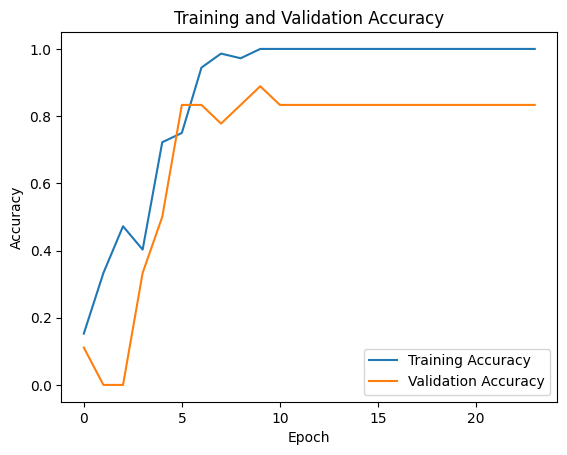

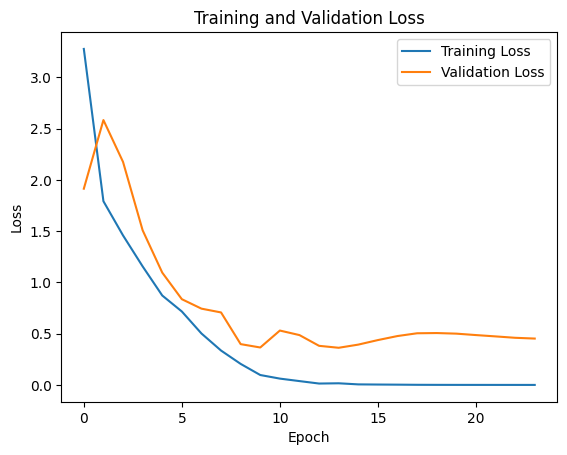

In [15]:
# Plot accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()